# Camera calibration using CHARUCO

In [311]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

In [312]:
workdir = "./workdir/"
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
board = aruco.CharucoBoard((5, 5), 0.08, 0.06, aruco_dict)
# imboard = board.draw((2000, 2000))
# cv2.imwrite(workdir + "chessboard.tiff", imboard)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
# ax.axis("off")
# plt.show()


And take photos of it from multiple angles, for example:

In [313]:
datadir = "./cameras/camera2_rgb/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['./cameras/camera2_rgb/frame_000000.png',
       './cameras/camera2_rgb/frame_000001.png',
       './cameras/camera2_rgb/frame_000002.png',
       './cameras/camera2_rgb/frame_000003.png',
       './cameras/camera2_rgb/frame_000004.png',
       './cameras/camera2_rgb/frame_000005.png',
       './cameras/camera2_rgb/frame_000006.png',
       './cameras/camera2_rgb/frame_000007.png',
       './cameras/camera2_rgb/frame_000008.png',
       './cameras/camera2_rgb/frame_000009.png'], dtype='<U38')

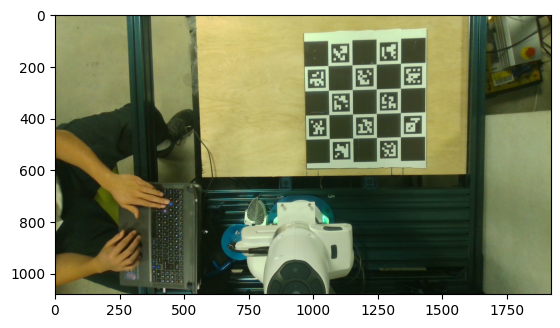

In [314]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [315]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [316]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image ./cameras/camera2_rgb/frame_000000.png
=> Processing image ./cameras/camera2_rgb/frame_000001.png
=> Processing image ./cameras/camera2_rgb/frame_000002.png
=> Processing image ./cameras/camera2_rgb/frame_000003.png
=> Processing image ./cameras/camera2_rgb/frame_000004.png
=> Processing image ./cameras/camera2_rgb/frame_000005.png
=> Processing image ./cameras/camera2_rgb/frame_000006.png
=> Processing image ./cameras/camera2_rgb/frame_000007.png
=> Processing image ./cameras/camera2_rgb/frame_000008.png
=> Processing image ./cameras/camera2_rgb/frame_000009.png


In [317]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    # print("CAMERA CALIBRATION")
    cameraMatrixInit = np.array([[ 1361.57,    0., 956.298],
                [    0., 1361.57, 546.581],
                [    0.,    0.,         1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    # flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    # # print pose
    # for i in range(len(rotation_vectors)):
    #     print("Rotation Vector:\n {0}".format(rotation_vectors[i]))
    #     print("Translation Vector:\n {0}".format(translation_vectors[i]))


    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [318]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

In [319]:
ret

0.32308588160728513

In [320]:
print("Camera matrix : \n {0}".format(mtx))

# mtx = np.array([[ 1361.57,    0., 956.298],
#                 [    0., 1361.57, 546.581],
#                 [    0.,    0.,         1.]])

Camera matrix : 
 [[1.33576551e+03 0.00000000e+00 9.64646158e+02]
 [0.00000000e+00 1.33576551e+03 8.13325735e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [321]:
print(dist)

# dist = np.zeros((5,1))

[[ 4.59591049e-02]
 [-1.40699647e-01]
 [ 1.43101047e-02]
 [-2.91164597e-03]
 [ 3.02507050e+00]
 [-6.70972362e-02]
 [-1.12807178e-01]
 [ 2.97098351e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


### Check calibration results

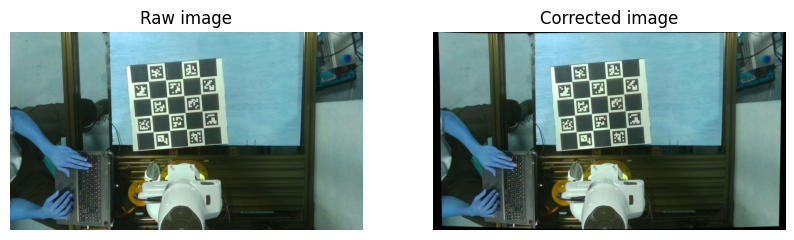

In [322]:
i=5 # select image id
plt.figure(figsize=(10,10))
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

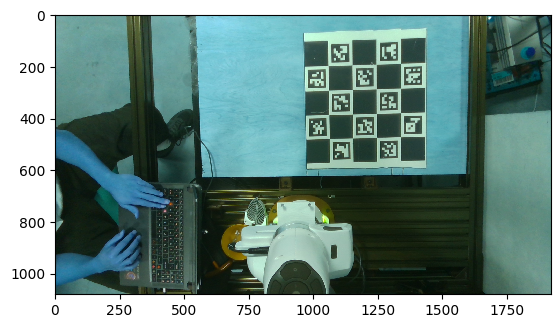

In [323]:

frame = cv2.imread("./cameras/camera2_rgb/frame_000000.png")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [324]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

(array([[[1254.2913  ,  110.31706 ],
         [1323.8221  ,  107.649635],
         [1323.5251  ,  179.1263  ],
         [1254.1929  ,  181.43184 ]]], dtype=float32),
 array([[[1066.7394  ,  116.26303 ],
         [1136.2854  ,  114.175186],
         [1136.524   ,  185.15747 ],
         [1068.1735  ,  187.4394  ]]], dtype=float32),
 array([[[1348.1918 ,  203.95323],
         [1417.4785 ,  201.70367],
         [1417.2837 ,  272.1419 ],
         [1347.838  ,  274.26904]]], dtype=float32),
 array([[[1160.9712 ,  210.08273],
         [1230.0586 ,  207.7794 ],
         [1230.2197 ,  278.2022 ],
         [1161.6041 ,  280.11356]]], dtype=float32),
 array([[[1254.6222 ,  302.73175],
         [1323.5872 ,  300.55402],
         [1323.4412 ,  369.9174 ],
         [1254.73   ,  372.0679 ]]], dtype=float32),
 array([[[ 975.70966,  215.53221],
         [1044.5225 ,  213.73201],
         [1045.5396 ,  283.32303],
         [ 977.4626 ,  285.367  ]]], dtype=float32),
 array([[[1069.6962 ,  307.90298],
 

Very fast processing !

## Results

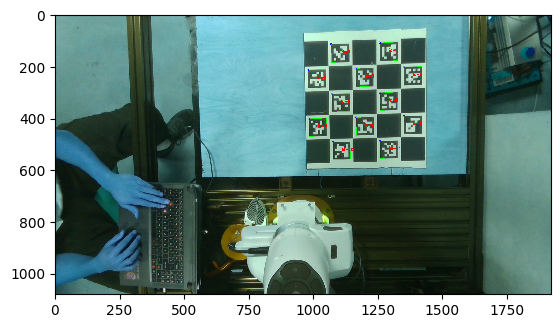

In [325]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [326]:
# 检测Charuco角点
resp, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, frame, board)

# 如果检测到足够的角点，则估计姿态
if resp > 10:
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, board, mtx, dist, None, None)
    
    print("Rotation Vector:\n {0}".format(tvec))

Rotation Vector:
 [[-0.00185044]
 [-0.6099445 ]
 [ 1.15868256]]


In [327]:
size_of_marker =  0.06 # side lenght of the marker in meter
res = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
rvecs, tvecs = res[0], res[1]

In [328]:
length_of_axis = 0.1
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvecs)):
    imaxis = cv2.drawFrameAxes(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

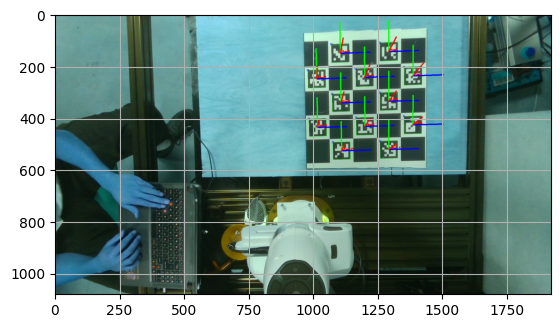

In [329]:
plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()

In [330]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

,tx,ty,tz
marker,,,
0,0.120631,-0.582309,1.180087
1,0.284084,-0.588703,1.184705
2,0.041079,-0.497389,1.180066
3,0.203233,-0.502479,1.182313
4,0.366605,-0.507854,1.186462
5,0.123765,-0.418807,1.184360
6,0.286873,-0.423965,1.188965
7,0.044686,-0.336709,1.191236
8,0.206649,-0.339802,1.189114


In [331]:
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"], 
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)


,rx,ry,rz
marker,,,
0,6.911661,-33.363846,67.613985
1,16.276794,-33.730214,67.878594
2,2.353651,-28.498295,67.612829
3,11.644420,-28.789909,67.741558
4,21.004926,-29.097873,67.979286
5,7.091205,-23.995901,67.858841
6,16.436593,-24.291433,68.122694
7,2.560317,-19.291993,68.252818
8,11.840118,-19.469211,68.131228


In [332]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.16351269, 0.25866007, 0.1632543 ])

In [333]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[ 0.99972225, -0.01956112, -0.01314449],
        [-0.01886111, -0.99849902,  0.05141951],
        [-0.01413058, -0.0511573 , -0.99859064]]),
 array([[-1.72614927e-04, -1.26498826e-02,  5.69659810e-03,
          1.20517148e-03,  5.14031817e-02,  9.98624090e-01,
         -1.38209378e-02, -9.98461136e-01,  5.13462442e-02],
        [-1.24324638e-02, -6.46538669e-01,  1.65855126e-02,
         -6.46671861e-01,  1.19399732e-02, -5.34620079e-03,
         -1.64225585e-02,  1.41713351e-02, -4.93602708e-04],
        [-8.82552284e-03, -1.64690968e-02, -6.46728798e-01,
          1.66320509e-02, -3.50785870e-04, -7.11021423e-04,
         -6.46595606e-01,  1.31440326e-02,  8.47630348e-03]]))

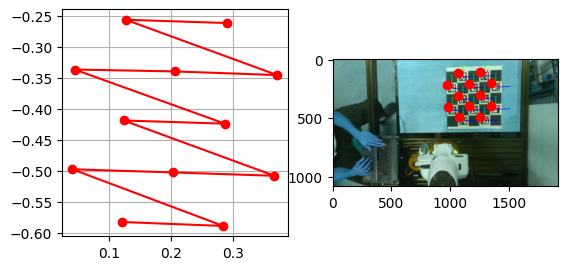

In [334]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "upper")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

In [335]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [336]:
import pickle

In [337]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [338]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [339]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,116.263031,1066.739380
1,110.317062,1254.291260
2,215.532211,975.709656
3,210.082733,1160.971191
4,203.953232,1348.191772
5,307.902985,1069.696167
6,302.731750,1254.622192
7,403.643921,980.054138
8,399.181244,1162.692749
9,394.162537,1347.695435


In [340]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


KeyError: 43

In [ ]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [ ]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13

In [ ]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints]]]]) -> corners, ids, rejectedImgPoints



(480, 640, 3)